# Custom observable example
This notebook implements a custom version of realspace_tb.Observable() to measure the electric dipole moment of a 2D system during time evolution.
Observable is implemented backend-aware to support both numpy and cupy arrays during the simulation.

In [ ]:
# If realspace_tb is not yet installed, run the following.
# Assuming you are in the /examples directory of the repository,
# else change the relative path from '..'.
%pip install -e ..

In [1]:
import realspace_tb as tb
from realspace_tb import orbitronics_2d as orb2d
from realspace_tb import backend as B
import numpy as np

B.set_backend(
    use_gpu=False
)  # Set to True to use GPU acceleration if cupy is available

In [ ]:
class DipoleMomentObservable(tb.Observable):
    """Observable to measure the electric dipole moment of the system in 2D.
    The dipole moment is computed as P = sum_i r_i * n_i, where r_i are the site positions and n_i the site occupations.
    """

    def __init__(
        self,
        geometry: orb2d.Lattice2DGeometry,
        window: tb.MeasurementWindow = tb.MeasurementWindow(),
    ) -> None:
        super().__init__(window)

        self._positions = B.xp().array(geometry.site_positions)  # shape (N, 2)
        self._origin = B.xp().array(geometry.origin)

        # Approximate system area by Lx * Ly
        self._system_area = geometry.Lx * geometry.Ly

    def _compute(self, rho: B.Array, t: float) -> B.Array:
        centered = self._positions - self._origin  # shape (N, 2)
        site_densities = B.xp().real(B.xp().diag(rho))  # shape (N,)
        return (
            B.xp().sum(centered * site_densities[..., None], axis=0) / self._system_area
        )

In [ ]:
class ConstantFieldAmplitude(orb2d.HomogeneousFieldAmplitude):
    """Constant (time-independent) homogeneous electric field amplitude."""

    def __init__(self, E0: float, direction: B.FCPUArray):
        self.E0 = B.FDTYPE(E0)
        self.direction = B.FDTYPE(direction)

    def at_time(self, t: "float | B.Array") -> "float | B.Array":
        if B.xp().isscalar(t):
            return self.E0
        return B.xp().full_like(t, self.E0, dtype=B.FDTYPE)

In [ ]:
# Simulate a system of graphene-like lattice under a constant electric field
# y~0 row of sites is initially occupied and driven towards y~Ly row

H = orb2d.LinearFieldHamiltonian(
    geometry=orb2d.HoneycombLatticeGeometry(Lx=11, Ly=10),
    field_amplitude=ConstantFieldAmplitude(E0=0.1, direction=B.xp().array([0.0, -1.0])),
)

N = H.geometry.Lx * H.geometry.Ly
rho = B.xp().zeros((N, N), dtype=B.DTYPE)
rho[0:10, 0:10] = 1.0  # Localized initial state at y~0 row

pol = DipoleMomentObservable(H.geometry)

animation = orb2d.observables.LatticeFrameObservable(
    H.geometry,
    window=tb.MeasurementWindow(stride=30),
)

tb.RK4NeumannSolver().evolve(
    rho,  # density matrix is modified in place
    H,  # Hamiltonian
    dt=0.01,  # time step size
    total_time=30.0,
    observables=[pol, animation], 
)

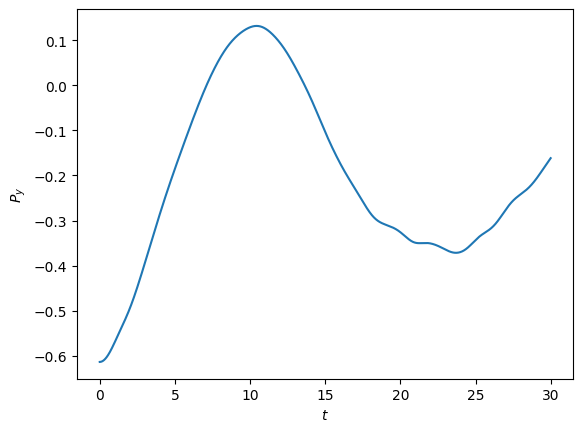

In [107]:
# Plot y-component of dipole moment over time
# Expect initially negative moment (since origin is at center as default)
# and later positive as charge is driven upwards across center.
import matplotlib.pyplot as plt

plt.plot(pol.measurement_times, pol.values[:, 1])
plt.xlabel("$t$")
plt.ylabel(r"$P_y$")
plt.show()

In [ ]:
orb2d.save_simulation_animation(
    animation,
    "dipole_moment.mp4", # save a video animation of the simulation at this path
    show_oam_direction_arrows=False,
    show_oam_indicators=False,
)